In [1]:
import json
from pathlib import Path
with open(Path("../../data") / "coding_results" / "open_coding.json", "r") as f:
    data = json.load(f)

In [2]:
len(data)

69744

In [3]:
import numpy as np
import pandas as pd

In [4]:
data = list(set(data))

len(data)

47524

In [5]:
from tqdm import tqdm
from langchain_community.embeddings import HuggingFaceEmbeddings
from sklearn.cluster import KMeans


texts = data

# 1) 构建 embedding 模型
embedder = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# 2) 批处理生成向量
def embed_batch(batch, batch_size=256):
    vecs = []
    for i in tqdm(range(0, len(batch), batch_size)):
        chunk = batch[i : i+batch_size]
        vecs.extend(embedder.embed_documents(chunk))
    return np.array(vecs, dtype="float32")

embeddings = embed_batch(texts, batch_size=256)


/var/folders/62/vmrfthrn35745lgpsxm8k8fh0000gn/T/ipykernel_44356/4174032964.py:9: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embedder = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
100%|██████████| 186/186 [00:21<00:00,  8.54it/s]


In [6]:
embeddings.shape

(47524, 384)

In [ ]:
from sklearn.decomposition import PCA, tSNE
import hdbscan

# 先压到 50 维
pca = PCA(n_components=50, random_state=42)
emb_50d = pca.fit_transform(embeddings)

tsne = tSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(embeddings)

# 再 HDBSCAN
hdbscan_labels = hdbscan.HDBSCAN(
    min_cluster_size=20,
    metric="euclidean"
).fit_predict(emb_50d)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Computing silhouette scores:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Computing silhouette scores: 100%|██████████| 10/10 [01:54<00:00, 11.42s/it]


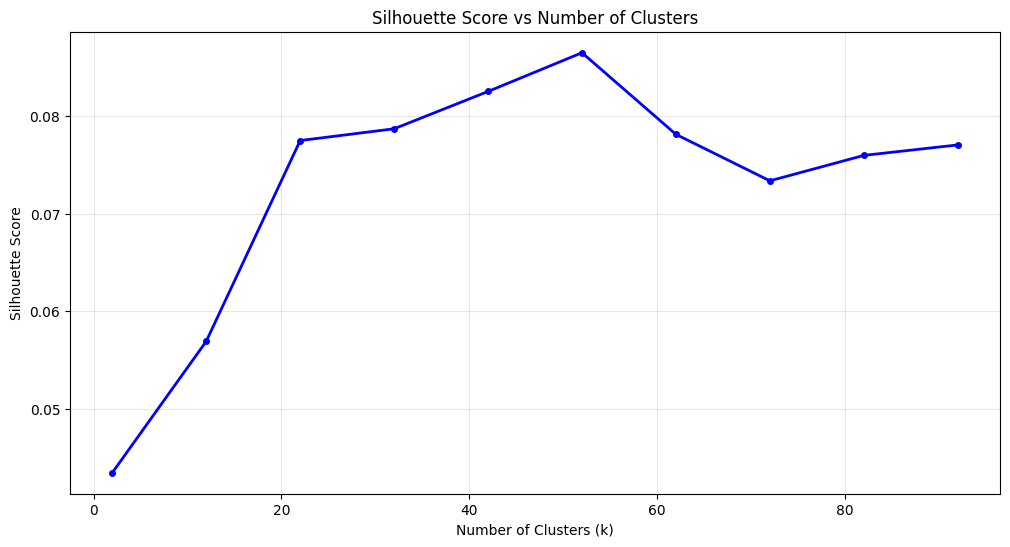

Best k: 52, Best silhouette score: 0.0865


In [8]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 计算轮廓系数，从 k=2 到 100 遍历（k=1 无法计算轮廓系数）
k_range = range(2, 101, 10)
silhouette_scores = []

for k in tqdm(k_range, desc="Computing silhouette scores"):
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init="auto"
    )
    labels = kmeans.fit_predict(emb_50d)
    score = silhouette_score(emb_50d, labels)
    silhouette_scores.append(score)

# 绘制轮廓系数图
plt.figure(figsize=(12, 6))
plt.plot(k_range, silhouette_scores, 'bo-', linewidth=2, markersize=4)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.grid(True, alpha=0.3)
plt.show()

# 找到最佳 k 值
best_k = k_range[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)
print(f"Best k: {best_k}, Best silhouette score: {best_score:.4f}")

# 使用最佳 k 值进行聚类
kmeans_labels = KMeans(
    n_clusters=best_k,
    random_state=42,
    n_init="auto"
).fit_predict(embeddings)


In [10]:
df = pd.DataFrame({
    "text": texts,
    "kmeans_label": kmeans_labels,
    "hdbscan_label": hdbscan_labels
})

df

,text,kmeans_label,hdbscan_label
0,Exploring data selling,1,-1
1,AI-induced challenges,12,-1
2,Mitigating compatibility problems,19,-1
3,Simplifying sign-up process,49,-1
4,Fixing issues through documentation,9,-1
...,...,...,...
47519,Learning automation tools,25,-1
47520,Simplifying choice,24,-1
47521,Seeking guidance on vibe coding,20,12
47522,Acknowledging AI use,12,-1


In [13]:
data = {}

for i in df['hdbscan_label'].unique():
    data[str(i)] = df[df['hdbscan_label'] == i]['text'].tolist()


data


{'-1': ['Exploring data selling',
  'AI-induced challenges',
  'Mitigating compatibility problems',
  'Simplifying sign-up process',
  'Fixing issues through documentation',
  'Realizing limitations of AI guidance',
  'Observing Attention Patterns',
  'Providing direct access',
  'Highlighting incomplete submissions',
  'Saving for future reference',
  'Encouraging new developers',
  'Encountering challenge',
  'Prioritizing foundational design',
  'Encouraging stable context',
  'Desiring recognition',
  'Guiding orchestration',
  'Maintaining slim files',
  'Enhancing design specs',
  'Speeding up script development',
  'Saving time on projects',
  'Integrating scripts for efficiency',
  'Relying on intuition',
  'Finding efficient alternatives',
  'Requesting additional specs',
  'Avoiding future rewrites',
  'Utilizing AI as trusted team members',
  'Ensuring backup options',
  'Running server flexibly',
  'Reducing barriers to software',
  'Switching models easily',
  'Reducing co

In [14]:
import json

with open("open-coding.json", "w") as f:
    f.write(json.dumps(data, indent=4))
